In [1]:
import os
import cv2
from Astar import get_AStarPlanner
import apriltag
import numpy as np
from rohm import load_tag_pos, ExtraInfoLoader
from utils import run_action, wait_req, angle
from sift import judge
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
def updateImage():
    """更新图像"""
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

In [59]:
def get_location():
    """实例化检测器并检测Apriltag."""
    # 内参矩阵
    fx = 192.0513
    fy = 194.1294
    cx = 311.9018
    cy = 233.6934
    intrinsic_matrix =  np.array([[fx, 0, cx],
                                  [0, fy, cy],
                                  [0, 0, 1]], dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.2683, -0.2053, 0, 0])
    
    img = updateImage()
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 直方图均衡
#     equalized_gray = cv2.equalizeHist(gray)
#     gray = equalized_gray
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)
#     print(tags)
    cnt = 0
    while len(tags) == 0:
        img = updateImage()
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         equalized_gray = cv2.equalizeHist(gray)
#         gray = equalized_gray
        tags = detector.detect(gray)
        cnt += 1
        if cnt >= 3:
            run_action('turn003L')
            wait_req()
            run_action('Back2Run')
            wait_req()
            cnt = 0

    tag_positions = load_tag_pos() # 获取pos和corners的代码

    # 获取pos和corners的代码
    tag_ids = [tag.tag_id for tag in tags]
    print("tag_ids: ", tag_ids)
    ImgPoints, WorldPoints = [], []
    for n, tag in enumerate(tags):
        # debug
#         if tag.tag_id >= 43 and tag.tag_id <= 71 :
#             continue
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        WorldPoints.append(tag_positions[str(tag.tag_id)]) # 3D坐标
        ImgPoints.append(np.array(tag.corners)) # 2D坐标

    ImgPoints = np.concatenate(ImgPoints, axis=0)
    WorldPoints = np.concatenate(WorldPoints, axis=0)

    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints, ImgPoints, intrinsic_matrix, distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    # R矩阵的第三行
    direction = np.matrix(rotM)[2]
    # print("朝向::",direction)
    x_robot, y_robot = cameraPosition[0], cameraPosition[1]

    dirXY = direction[:,:2]
    normdir = dirXY / np.linalg.norm(dirXY)
#     print(x_robot.tolist()[0][0], y_robot.tolist()[0][0])
    if y_robot.tolist()[0][0]>315 or y_robot.tolist()[0][0]<-5 or x_robot.tolist()[0][0]>315 or x_robot.tolist()[0][0]<-5:
        run_action('Forwalk02')
        wait_req()
        return get_location()
    else:
        return y_robot.tolist()[0][0], x_robot.tolist()[0][0], normdir 

In [23]:
def angle_normalize(delta):
    if delta > 180:
        delta = delta - 360 
    elif delta < -180:
        delta = delta + 360
    return delta
    

def rotate_to_balance(target, n_meas=5):
    """调整机器人朝向。
    Args:
        target (float): 目标朝向的角度。
    """
    thetas = []
    for i in range(0, n_meas):
        _, _, dirs= get_location()
        thetas.append(angle(dirs))
    theta = np.median(thetas)

    # 设置一个物理上的零点,可供机器人调参数
    delta = angle_normalize(theta - target)
    print("***** Delta:", delta)
    print("***** Theta=", theta)
    print("***** Target angle:", target)
    
    if delta > 0: # left
        for i in range(0, int(abs(delta)/30)):
            run_action('turn004L')
            wait_req()
    elif delta < 0: # right
        for i in range(0, int(abs(delta)/10)):
            run_action('turn004R')
            wait_req()

    Y, X, dirs = get_location()
    theta = angle(dirs)
    delta = angle_normalize(theta - target)
    print("***** Location:", (X, Y))
    print("***** Delta:", delta)
    print("***** Theta=", theta)
    print("***** Target angle:", target)

    while abs(delta) > 13: # 最后再微调一下
        # if abs(delta) >= 70: # 优化版了rotate函数,对于转弯过大的情况单独处理
        #     print("----- LARGE TURN!")
        #     if delta > 0:
        #         run_action('turn010L')
        #         wait_req()
        #     elif delta < 0:
        #         run_action('turn010R')
        #         wait_req()
        # elif abs(delta) > 35:
        #     print("----- MEDIUM TURN!")
        #     if delta > 0:
        #         run_action('turn005L')
        #         wait_req()
        #     elif delta < 0:
        #         run_action('turn005R')
        #         wait_req()
        # else: 
        print("----- SMALL TURN!")
        if delta > 0:
            run_action('turn001L')
        elif delta < 0:
            run_action('turn001R')

        Y, X, dirs = get_location()
        theta = angle(dirs)
        delta = angle_normalize(theta - target)
        print("***** Location:", (X, Y))
        print("***** Delta:", delta)
        print("***** Theta=", theta)
        print("***** Target angle:", target)

    print("Adjusting angle completed! Theta=",theta)
    
    return

In [24]:
# 获得下一个点的二维坐标，并移动
def move_to_next(next_loction_X, next_loction_Y, threshold=20):
    """从当前位置（拍照计算得到）移动到目标点"""
    Y, X ,_ = get_location()
    move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]]) # 位移矢量
    distance = np.linalg.norm(move_dir)
    print("Distance: ", distance)
    norm_move_dir = move_dir / distance
    print("***** norm_move_dir = ",norm_move_dir)

    while distance > threshold:
        target_theta = angle(norm_move_dir) # 确定目标角度
        print('***** target angle:', target_theta)
        print('***** target postion:', next_loction_X, next_loction_Y)
        rotate_to_balance(target_theta)
        print('***** Already located!Forward!!!')
        wait_req()
        run_action('fastForward03')
        wait_req()
        Y, X, _ = get_location()
        print('***** Location:', (X, Y))
        move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
        distance = np.linalg.norm(move_dir)
        norm_move_dir = move_dir / distance
        print("Distance: ", distance)
        print("***** norm_move_dir = ", norm_move_dir)
    print("Already arrived!!!")
    return

In [25]:
# Test 模块
# a_star = get_AStarPlanner(grid_size=8)
# sx = 15
# sy = 15
# tx = 170
# ty = 200
# rx, ry = a_star.planning(sx, sy, tx, ty)
# plt.plot(sy, sx, "og")
# plt.plot(ty, tx, "xb")
# plt.plot(ry, rx, "-r")
# print(rx,ry)

In [26]:
def refine(x, y, dir):
    '''
    首先调节到x和y，再调方向
    '''
    move_to_next(next_loction_X=x,next_loction_Y=y)
    target_theta = angle(dir)
    rotate_to_balance(target_theta)

    return

In [27]:
def rush(pillar):
    '''冲向按钮的函数'''
    # 调整一次位置
    # refine(x=pillar[0][0],y=pillar[0][1],dir=pillar[1])
    # 冲到按钮的位置,实际上可以加入微调的模块
    run_action('fastForward03')
    wait_req()
    # 再调整一次朝向
    rotate_to_balance(pillar[1])
    wait_req()
    # 冲向按钮撞击按钮
    print('冲啊！！！')

    run_action('fastForward05')
    
    return 0

def leave(step):
    '''从按按钮位置远离'''
    for i in range(step):
        run_action('Back2Run')
        wait_req()
    return 0

In [28]:
def decision():
    """判断自己是不是在“好格点”，如果在，转头看向附近的柱子侧面，识别是否出现了目标花朵。
    
    Returns:
        int: 识别到的花种类编号（如果没识别到为0）。
        int: 识别到的花旁边的apriltag编号。
    """
    
    goodnodes = [[150,120, [70,71]]] # 这个70不确定！是指侧面右上角的tag标识编号

    Y, X, _ = get_location()
    for goodnode in goodnodes:
        distance = (X-goodnode[0])^2 + (Y-goodnode[1])^2
        if distance < 25:
            print('Good point! Searching for flowers...')
            
            # 开始转头，拍拍
            for extent in ['180 ','140','MM','020','010']:
                k = 'HeadTurn' + extent
                run_action(k)
                wait_req()
                img = updateImage()
                img = np.array(img)

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                options = apriltag.DetectorOptions(families='tag36h11',)
                detector = apriltag.Detector(options)
                H, W = gray.shape
                gray_cut = gray[:,W//4:3*W//4]
                tags = detector.detect(gray_cut)
                tags_ids = [tag.tag_id for tag in tags]

                # 识别到需要看的侧面，然后对其花朵进行识别
                for goodtag_id in goodnode[2]:
                    if goodtag_id in tags_ids:
                        for i in range(1,7):
                            target_img = cv2.imread('flower/%s.jpg'%i, 1)
                            if judge(img1=img, img2=target_img, threshold=10):
                                print("Flower detected! Class:%s"%i)
                                return i, goodtag_id
                        return 0, goodtag_id
            
        return 0, 0 # 没有在goodnode旁边 / 向左向右看完都没有成功识别goodnode的tag 


In [29]:
def Go_Best(sx,sy, fx,fy, correct_type):
    EIL = ExtraInfoLoader(load_tag_pos())
    a_star = get_AStarPlanner(grid_size=30)
    rx, ry = a_star.planning(sx, sy, fx, fy)
    i = 1
    flag = False # 是否识别到了正确的花
    while i < len(rx):  
        if not flag: # 如果已经找到了就不找了，直接走向终点
            flower_type, tag_id = decision()
            # 回正脑袋
            run_action('HeadTurnMM')
            wait_req()
            if flower_type == correct_type: # 找到了正确的花
                flag = True
                print("***** Target Flower deteced!!! *****")

                # 调整位置和朝向
                button_pos, s, screen_orientation = EIL.get_extra_info(tag_id)
                rush_dir = [-screen_orientation[0], - screen_orientation[1]]
                rush_location = button_pos - 40 * rush_dir
                move_to_next(rush_location[0], rush_location[1])
                target_theta = angle(rush_dir)
                rotate_to_balance(target_theta)

                # 冲冲！
                pillar = [rush_location, rush_dir]
                rush(pillar)

                leave(2) # 远离
         
        move_to_next(rx[i],ry[i])
        i += 1

In [91]:
# Test4 测试距离40cm按按钮函数是否合理

def push_button(x,y):
    if y < 50 and x > 35 and x < 110:
        for i in range(3):
            run_action('Forwalk02')
            wait_req()
        # 转向冲
        run_action('turn010R')
        wait_req()
        run_action('turn005R')
        wait_req()
        run_action('fastForward03')
        wait_req()
        # 后退
        for i in range(3):
            run_action('Back2Run')
            wait_req()
        # 转回来
        run_action('turn010L')
        wait_req()
        # 左走
        run_action('Left3move')
        wait_req()
        run_action('Left3move')
        wait_req()
        # 转回来
        run_action('turn005L')
        wait_req()
    elif x < 25 and y > 35 and y < 110:
        for i in range(3):
            run_action('Forwalk02')
            wait_req()
        # 转向冲
        run_action('turn010L')
        wait_req()
        run_action('turn010L')
        wait_req()
        run_action('fastForward03')
        wait_req()
        # 后退
        for i in range(3):
            run_action('Back2Run')
            wait_req()
        # 转回来
        run_action('turn010R')
        wait_req()
        # 右走
        run_action('Right3move')
        wait_req()
        run_action('Right3move')
        wait_req()
        run_action('turn005R')
        wait_req()
        
    elif x > 210 and y > 100 and y < 200:
        run_action('turn010R')
        wait_req()
        run_action('turn005R')
        wait_req()
        run_action('fastForward03')
        wait_req()
        # 后退
        for i in range(3):
            run_action('Back2Run')
            wait_req()
        # 转正
        run_action('turn010L')
        wait_req()
        # 左走
        for i in range(2):
            run_action('Left3move')
            wait_req()
        run_action('turn010L')
        wait_req()

    elif y > 240 and x > 100 and x < 220:
        run_action('turn010R')
        wait_req()
        run_action('turn005R')
        wait_req()
        run_action('fastForward03')
        wait_req()
        # 后退
        for i in range(3):
            run_action('Back2Run')
            wait_req()
        # 转正
        run_action('turn010L')
        wait_req()
        # 左走
        for i in range(3):
            run_action('Left3move')
            wait_req()
        for i in range(2):
            run_action('turn010L')
            wait_req()

In [92]:
# 80 10
# 10 80
# 200 290
# 290,150
push_button(290,150)

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read 

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


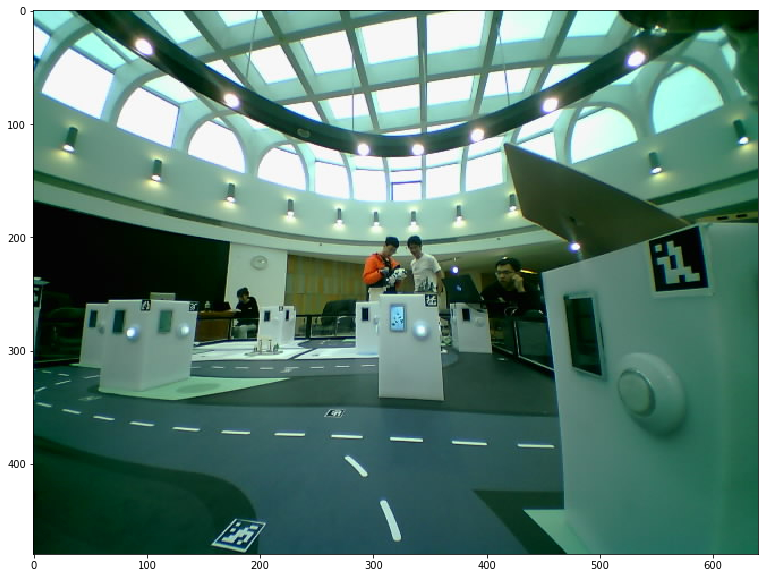

In [55]:
img = updateImage()
plt.figure(figsize=(14,10))
plt.imshow(img)

In [36]:
# Test1 测试位置和朝向计算是否正确
Y, X, direction = get_location()
print("Robot的X坐标为:",X)
print("Robot的Y坐标为:",Y)
print("朝向为:", direction)
theta = angle(direction)
print("角度为:",theta)

move_dir = np.array([[230-X, 120-Y]]) # 位移矢量
distance = np.linalg.norm(move_dir)
norm_move_dir = move_dir / distance
print("***** norm_move_dir = ",norm_move_dir)
print(angle(norm_move_dir))

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
tag_ids:  [30, 80]
Robot的X坐标为: 163.85782521503228
Robot的Y坐标为: 243.06628167532162
朝向为: [[-0.07533496 -0.99715828]]
角度为: [[-94.31794174]]
***** norm_move_dir =  [[ 0.47341006 -0.88084216]]
[-61.74594127]


In [14]:
rotate_to_balance(90)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
tag_ids:  [30, 50, 57, 80]
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling bann

KeyboardInterrupt: 

In [ ]:
move_to_next(150,150)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...


In [ ]:
# Test2 测试move_to_next函数是否正确
# XY = [[230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]]
XY = [[210,180],[180,150]]
for xy in XY:
    move_to_next(xy[0],xy[1])

In [ ]:
a_star = get_AStarPlanner(grid_size=30)
rx, ry = a_star.planning(sx, sy, fx, fy)
for x, y in zip(rx, ry):
    move_to_next(x,y)

In [ ]:
# Test3 测试不判断花是否能正常走到终点


In [ ]:
# case 1:
# 起点:[280, 120] 终点:[20, 180]  
# 具体过程点：[280,116], [280,124], [230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]

# 距离40cm进行冲撞，中间柱子面点:( , ),( , )

# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 2:
# 起点:[20,86] 终点:[165,260] 
# 具体过程点：[20,86], [20,130], [20,180], [60,180], [60,220], [60,260], [115,260], [165,260]
# 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 3:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 4:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按
